In [ ]:
conda install -c conda-forge imbalanced-learn

In [243]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [1342]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import imblearn
from collections import Counter

In [1295]:
df = pd.read_csv('Data v2.csv')

In [1505]:
#Full list of features for data sinfo(et
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844351 entries, 0 to 844350
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   acc_open_past_24mths  844351 non-null  int64  
 1   addr_state            844351 non-null  object 
 2   annual_inc            844351 non-null  float64
 3   application_type      844351 non-null  object 
 4   avg_cur_bal           844351 non-null  int64  
 5   emp_length            844351 non-null  int64  
 6   dti                   844351 non-null  float64
 7   grade                 844351 non-null  int64  
 8   home_ownership        844351 non-null  int64  
 9   il_util               844351 non-null  float64
 10  inq_fi                844351 non-null  float64
 11  inq_last_12m          844351 non-null  float64
 12  int_rate              844351 non-null  float64
 13  installment           844351 non-null  float64
 14  issue_d               844351 non-null  object 
 15  

In [1297]:
df.loan_status.value_counts()

1    800173
0     44178
Name: loan_status, dtype: int64

In [1298]:
#Dropping features that showed high multicollinearity
dataset=df.drop(['addr_state' , 'application_type' , 'verification_status' , 'issue_d'] , axis = 1)

In [1506]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844351 entries, 0 to 844350
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   acc_open_past_24mths  844351 non-null  int64  
 1   annual_inc            844351 non-null  float64
 2   avg_cur_bal           844351 non-null  int64  
 3   emp_length            844351 non-null  int64  
 4   dti                   844351 non-null  float64
 5   grade                 844351 non-null  int64  
 6   home_ownership        844351 non-null  int64  
 7   il_util               844351 non-null  float64
 8   inq_fi                844351 non-null  float64
 9   inq_last_12m          844351 non-null  float64
 10  int_rate              844351 non-null  float64
 11  installment           844351 non-null  float64
 12  loan_status           844351 non-null  int64  
 13  loan_amnt             844351 non-null  int64  
 14  open_acc              844351 non-null  int64  
 15  

In [1363]:
X=dataset.drop(['loan_status'] , axis = 1)
y=dataset['loan_status']

### Undersample Dataset

In [1301]:
from sklearn.datasets import make_classification
import imblearn.under_sampling 

In [1302]:
#Split data into 3 sets: 60% train, 20% validation, 20% test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=11) 

In [1185]:
#1 = Loan is 'Current' (AKA borrower is current on payments)
#0 = Loan is 'Default' (AKA borrower has missed a payment(s))

y_train.value_counts()

1    480304
0     26306
Name: loan_status, dtype: int64

In [1186]:
#Undersample data set given the high amount of loans that are Current
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

ratio = {1 : n_pos , 0 : n_neg }

In [1187]:
undersample = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1 , random_state = 42)
X_under, y_under = undersample.fit_resample(X_train, y_train)

In [1188]:
y_under.value_counts()

0    26306
1    26306
Name: loan_status, dtype: int64

### Feature Scaling and Splitting Datasest 

In [1189]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [1190]:
#Scaling Training Data
scaler = StandardScaler()
scaler.fit(X_under.values)

X_tr = scaler.transform(X_under.values)

In [1191]:
#Confirm scaling worked by checking standard deviation of features
X_tr.mean(axis=0)

array([ 1.29651225e-17, -2.80910988e-17,  1.51259763e-17,  5.48316640e-17,
       -1.90155130e-16,  9.93992727e-17,  4.21366482e-17, -2.22567937e-16,
       -3.02519526e-17,  7.13081739e-17, -1.64224885e-16, -2.09602814e-16,
        1.72598194e-16, -4.09211680e-17,  3.56540869e-17,  2.04470787e-16,
       -3.12243367e-16, -6.32049723e-17])

In [1192]:
X_tr.shape

(52612, 18)

In [1193]:
X_val.shape

(168870, 18)

### Creating Baseline Mode

For this analysis, four models were cross validated then fitted against the validation dataset. The four models are: Logistic Regression, kNN, Random Forest, and XGBoost. 

An average of the cross validation scores was then printed to choose the best model. 

In [615]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

ROC AUC score =  0.593817552028124


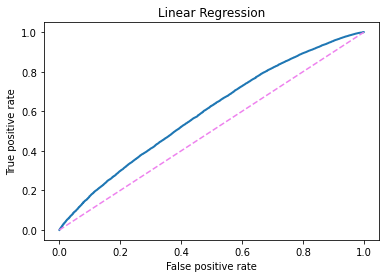

In [974]:
#Logistic Regression Baseline Model
lr = LogisticRegression(C=10)
lr.fit(X_under, y_under)

fpr, tpr, thresholds = roc_curve(y_val, lr.predict_proba(X_val)[:,1])

plt.title('Linear Regression')
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
print("ROC AUC score = ", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

ROC AUC score =  0.521886496011509


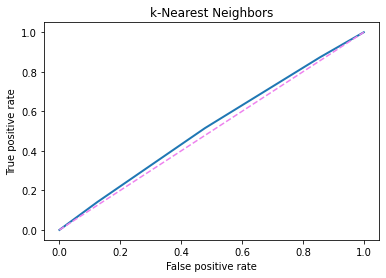

In [977]:
#KNN Baseline Model
kNN = KNeighborsClassifier(n_neighbors = 3, n_jobs = -1 , leaf_size = 40)
kNN.fit(X_under, y_under)

fpr, tpr, thresholds = roc_curve(y_val, kNN.predict_proba(X_val)[:,1])

plt.title('k-Nearest Neighbors')
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
print("ROC AUC score = ", roc_auc_score(y_val, kNN.predict_proba(X_val)[:,1]))

ROC AUC score =  0.7151939125884164


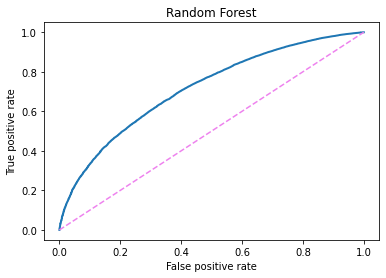

In [987]:
#Random Forest Baseline Model
rf = RandomForestClassifier(max_depth = 10)
rf.fit(X_under, y_under)

fpr, tpr, thresholds = roc_curve(y_val, rf.predict_proba(X_val)[:,1])

plt.title('Random Forest')
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
print("ROC AUC score = ", roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))


C:\Users\jayju\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:56:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC AUC score =  0.7305148286299761


NameError: name 'sqrt' is not defined

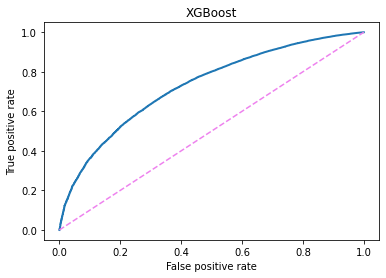

In [1341]:
#XGBoost Baseline Model
xgb_cl = xgb.XGBClassifier(n_estimators = 100 , max_depth = 5) 
xgb_cl.fit(X_under, y_under)

fpr, tpr, thresholds = roc_curve(y_val, xgb_cl.predict_proba(X_val)[:,1])

plt.title('XGBoost')
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
print("ROC AUC score = ", roc_auc_score(y_val, xgb_cl.predict_proba(X_val)[:,1]))

Based on the below scores, the XGBoost data is determined to be the best fit model for this project. 

### Final Data Fit and Predictions

In [1072]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score , precision_score

In [1073]:
xgboost = xgb.XGBClassifier(n_estimators=10000,
                       max_depth=6,
                       objective="reg:squarederror", 
                       learning_rate=0.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8)

In [1074]:
eval_set=[(X_under,y_under),(X_val,y_val)] 
fit_model = xgboost.fit( 
                    X_under, y_under, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=20,
                    verbose=True #gives output log as below
                   )

[0]	validation_0-rmse:0.49403	validation_1-rmse:0.49434
[1]	validation_0-rmse:0.48844	validation_1-rmse:0.48904
[2]	validation_0-rmse:0.48379	validation_1-rmse:0.48469
[3]	validation_0-rmse:0.48172	validation_1-rmse:0.48313
[4]	validation_0-rmse:0.47830	validation_1-rmse:0.48004
[5]	validation_0-rmse:0.47550	validation_1-rmse:0.47764


C:\Users\jayju\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-rmse:0.47273	validation_1-rmse:0.47514
[7]	validation_0-rmse:0.47055	validation_1-rmse:0.47334
[8]	validation_0-rmse:0.46859	validation_1-rmse:0.47180
[9]	validation_0-rmse:0.46695	validation_1-rmse:0.47050
[10]	validation_0-rmse:0.46537	validation_1-rmse:0.46926
[11]	validation_0-rmse:0.46416	validation_1-rmse:0.46840
[12]	validation_0-rmse:0.46303	validation_1-rmse:0.46758
[13]	validation_0-rmse:0.46210	validation_1-rmse:0.46701
[14]	validation_0-rmse:0.46094	validation_1-rmse:0.46610
[15]	validation_0-rmse:0.45989	validation_1-rmse:0.46538
[16]	validation_0-rmse:0.45904	validation_1-rmse:0.46489
[17]	validation_0-rmse:0.45837	validation_1-rmse:0.46464
[18]	validation_0-rmse:0.45764	validation_1-rmse:0.46428
[19]	validation_0-rmse:0.45697	validation_1-rmse:0.46389
[20]	validation_0-rmse:0.45635	validation_1-rmse:0.46367
[21]	validation_0-rmse:0.45587	validation_1-rmse:0.46344
[22]	validation_0-rmse:0.45529	validation_1-rmse:0.46322
[23]	validation_0-rmse:0.45478	vali

[149]	validation_0-rmse:0.42570	validation_1-rmse:0.45875
[150]	validation_0-rmse:0.42547	validation_1-rmse:0.45874
[151]	validation_0-rmse:0.42521	validation_1-rmse:0.45875
[152]	validation_0-rmse:0.42499	validation_1-rmse:0.45876
[153]	validation_0-rmse:0.42485	validation_1-rmse:0.45876
[154]	validation_0-rmse:0.42482	validation_1-rmse:0.45877
[155]	validation_0-rmse:0.42477	validation_1-rmse:0.45876
[156]	validation_0-rmse:0.42458	validation_1-rmse:0.45876
[157]	validation_0-rmse:0.42446	validation_1-rmse:0.45879
[158]	validation_0-rmse:0.42428	validation_1-rmse:0.45879
[159]	validation_0-rmse:0.42414	validation_1-rmse:0.45881
[160]	validation_0-rmse:0.42390	validation_1-rmse:0.45878
[161]	validation_0-rmse:0.42373	validation_1-rmse:0.45878
[162]	validation_0-rmse:0.42341	validation_1-rmse:0.45864
[163]	validation_0-rmse:0.42313	validation_1-rmse:0.45856
[164]	validation_0-rmse:0.42303	validation_1-rmse:0.45857
[165]	validation_0-rmse:0.42279	validation_1-rmse:0.45859
[166]	validati

In [1075]:
print(xgboost.score(X_val,y_val))

0.6554864688813881


In [1361]:
from numpy import sqrt
from numpy import argmax

gmeans = sqrt(tpr*(1-fpr))
ix = argmax(gmeans)

print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.487396, G-Mean=0.669


In [1076]:
print("The score for XGBoost is")
print("Training: {:6.2f}%".format(100*xgb_cl.score(X_val, y_val)))
print("Test set: {:6.2f}%".format(100*xgb_cl.score(X_test, y_test)))

The score for XGBoost is
Training:  65.18%
Test set:  64.98%


In [1077]:
print("The score for XGBoost is")
print("Training: {:6.2f}%".format(100*xgboost.score(X_val, y_val)))
print("Test set: {:6.2f}%".format(100*xgboost.score(X_test, y_test)))

The score for XGBoost is
Training:  65.55%
Test set:  65.47%


### Finding Maximum ARR based on Confusion Matrixes

In [1521]:
#XGBoost w/ Scores provided since it was highest performing model
threshold = .99

xgb_prob = xgboost.predict_proba(X_test)
xgb_predicted = (xgb_prob[:,1] >= threshold).astype('int')

xgb_f1 = f1_score(y_test , xgb_predicted)
xgb_pre = precision_score(y_test , xgb_predicted)
xgb_acc = accuracy_score(y_test , xgb_predicted)
xgb_rec = recall_score(y_test , xgb_predicted)


print("F1 Score: {:6.2f}%".format(100*xgb_f1))
print("Precision: {:6.2f}%".format(100*xgb_pre))
print("Accuracy: {:6.2f}%".format(100*xgb_acc))
print("Recall: {:6.2f}%".format(100*xgb_rec))


F1 Score:   0.41%
Precision:  99.70%
Accuracy:   5.45%
Recall:   0.20%


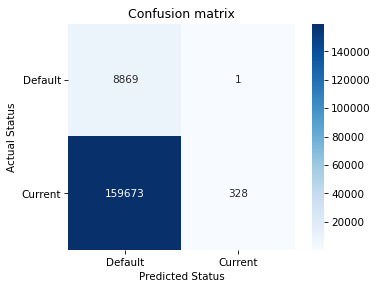

In [1529]:
#Confusion matrix to show results from chosen model
xgb_cm = confusion_matrix(y_test, xgb_predicted)
plt.figure(dpi=75)
sns.heatmap(xgb_cm, cmap=plt.cm.Blues, annot=True, square=True, fmt = 'd',
           xticklabels=['Default','Current'],
           yticklabels=['Default','Current'])
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status')
plt.title('Confusion matrix')
plt.yticks(rotation=0);

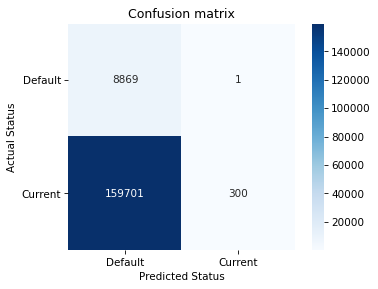

In [1508]:
threshold = .90

rf_prob = rf.predict_proba(X_test)
rf_predicted = (rf_prob[:,1] >= threshold).astype('int')

#Confusion matrix to show results from chosen model
rf_cm = confusion_matrix(y_test, rf_predicted)
plt.figure(dpi=75)
sns.heatmap(rf_cm, cmap=plt.cm.Blues, annot=True, square=True, fmt = 'd',
           xticklabels=['Default','Current'],
           yticklabels=['Default','Current'])
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status')
plt.title('Confusion matrix')
plt.yticks(rotation=0);

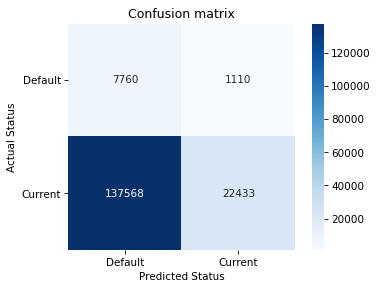

In [1516]:
threshold = .9

kNN_prob = kNN.predict_proba(X_test)
kNN_predicted = (kNN_prob[:,1] >= threshold).astype('int')

#Confusion matrix to show results from chosen model
kNN_cm = confusion_matrix(y_test, kNN_predicted)
plt.figure(dpi=75)
sns.heatmap(kNN_cm, cmap=plt.cm.Blues, annot=True, square=True, fmt = 'd',
           xticklabels=['Default','Current'],
           yticklabels=['Default','Current'])
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status')
plt.title('Confusion matrix')
plt.yticks(rotation=0);

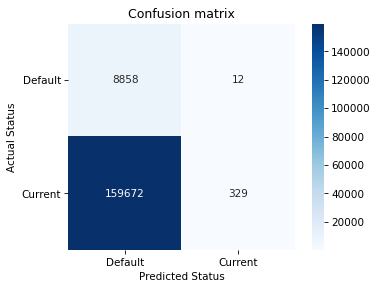

In [1510]:
threshold = .89

lr_prob = lr.predict_proba(X_test)
lr_predicted = (lr_prob[:,1] >= threshold).astype('int')

#Confusion matrix to show results from chosen model
lr_cm = confusion_matrix(y_test, lr_predicted)
plt.figure(dpi=75)
sns.heatmap(lr_cm, cmap=plt.cm.Blues, annot=True, square=True, fmt = 'd',
           xticklabels=['Default','Current'],
           yticklabels=['Default','Current'])
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status')
plt.title('Confusion matrix')
plt.yticks(rotation=0);

In [1535]:
#ARR Calculation
int_pmt = ((X['loan_amnt'].mean() * X['int_rate'].mean())/12)
avg_term = (X['term'].mean())
avg_loan_size = (X['loan_amnt'].mean())

print("Average interest payment: ${:2,.2f}".format(int_pmt))
print("Average loan term: {:2,.2f}".format(avg_term))
print("Average loan amount: ${:2,.2f}".format(avg_loan_size))

Average interest payment: $185.76
Average loan term: 43.29
Average loan amount: $16,241.59


In [1530]:
#Calculate ARR based on prediction recall and precision of each of the four models
RoR = (((xgb_cm[1][1] + xgb_cm[0][1]) * avg_loan_size) + (xgb_cm[1][1] * int_pmt * avg_term) - (xgb_cm[0][1] * avg_loan_size)) / ((xgb_cm[1][1] + xgb_cm[0][1]) * avg_loan_size)
xgb_ARR = RoR**(1/(avg_term/12)) - 1
print(xgb_ARR)

0.11699947674656763


In [1531]:
RoR = (((lr_cm[1][1] + lr_cm[0][1]) * avg_loan_size) + (lr_cm[1][1] * int_pmt * avg_term) - (lr_cm[0][1] * avg_loan_size)) / ((lr_cm[1][1] + lr_cm[0][1]) * avg_loan_size)
lr_ARR = RoR**(1/(avg_term/12)) - 1

print(lr_ARR)

0.10689555175864873


In [1532]:
RoR = (((kNN_cm[1][1] + kNN_cm[0][1]) * avg_loan_size) + (kNN_cm[1][1] * int_pmt * avg_term) - (kNN_cm[0][1] * avg_loan_size)) / ((kNN_cm[1][1] + kNN_cm[0][1]) * avg_loan_size)
kNN_ARR = RoR**(1/(avg_term/12)) - 1

print(kNN_ARR)

0.10307575822509896


In [1533]:
RoR = (((rf_cm[1][1] + rf_cm[0][1]) * avg_loan_size) + (rf_cm[1][1] * int_pmt * avg_term) - (rf_cm[0][1] * avg_loan_size)) / ((rf_cm[1][1] + rf_cm[0][1]) * avg_loan_size)
rf_ARR = RoR**(1/(avg_term/12)) - 1

print(rf_ARR)

0.11691165394136105


In [1534]:
print("XGBoost ARR Projection - Initial Investment of: ${:2,.0f}".format((xgb_cm[1][1] + xgb_cm[0][1]) * avg_loan_size), "and ARR of: {:2.2f}%".format(100*xgb_ARR))
print("LogReg ARR Projection - Initial Investment of: ${:2,.0f}:".format((lr_cm[1][1] + lr_cm[0][1]) * avg_loan_size),"and ARR of: {:2.2f}%".format(100*lr_ARR))
print("kNN ARR Projection - Initial Investment of: ${:2,.0f}:".format((kNN_cm[1][1] + kNN_cm[0][1]) * avg_loan_size), "and ARR of: {:2.2f}%".format(100*kNN_ARR))
print("Random Forest ARR Projection - Initial Investment of: ${:2,.0f}:".format((rf_cm[1][1] + rf_cm[0][1]) * avg_loan_size),"and ARR of:{:2.2f}%".format(100*rf_ARR))

XGBoost ARR Projection - Initial Investment of: $5,343,482 and ARR of: 11.70%
LogReg ARR Projection - Initial Investment of: $5,538,381: and ARR of: 10.69%
kNN ARR Projection - Initial Investment of: $382,375,696: and ARR of: 10.31%
Random Forest ARR Projection - Initial Investment of: $4,888,718: and ARR of:11.69%


In [1445]:
print(lr_cm[1][1] + lr_cm[0][1])

140


1    800173
0     44178
Name: loan_status, dtype: int64


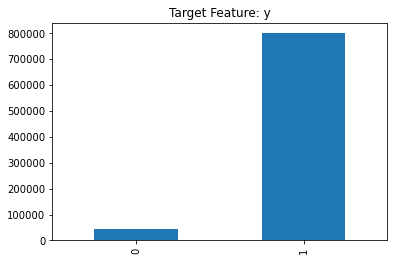

In [1392]:
y.value_counts().sort_index().plot.bar(x='Target Value', y='Number of Occurrences', title = 'Target Feature: y')
print(y.value_counts())

0    26306
1    26306
Name: loan_status, dtype: int64


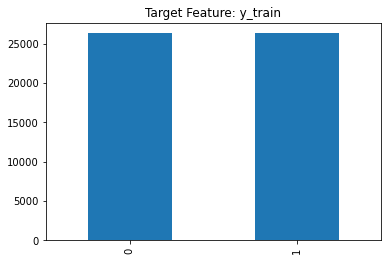

In [1316]:
y_under.value_counts().sort_index().plot.bar(x='Target Value', y='Number of Occurrences', title = 'Target Feature: y_train')
print(y_under.value_counts())

1    159868
0      9002
Name: loan_status, dtype: int64


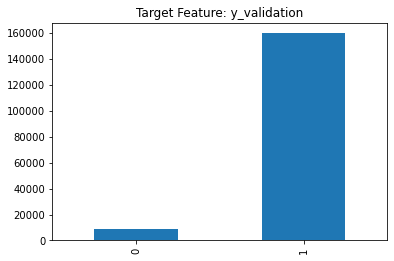

In [1318]:
y_val.value_counts().sort_index().plot.bar(x='Target Value', y='Number of Occurrences', title = 'Target Feature: y_validation')
print(y_val.value_counts())

1    160001
0      8870
Name: loan_status, dtype: int64


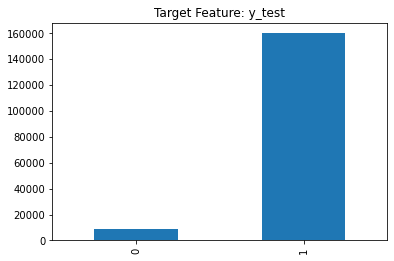

In [1320]:
y_test.value_counts().sort_index().plot.bar(x='Target Value', y='Number of Occurrences' , title = 'Target Feature: y_test')
print(y_test.value_counts())